In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env SEISMIQB_ANONYMIZE 1

import sys
import numpy as np
from copy import copy

PROJECT_PATH = '../' * 3
sys.path.insert(0, f'{PROJECT_PATH}seismiqb')
sys.path.insert(0, f'{PROJECT_PATH}src')

from seismiqb import SeismicDataset, HorizonMetrics, SeismicSampler

env: SEISMIQB_ANONYMIZE=1


../../../seismiqb/seismiqb/batchflow/batchflow/notifier.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as tqdm_auto


In [3]:
from glob import glob
GEOMETRY_PATH = '/data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.blosc'
HORIZONS_PATH = glob('/data/seismic_data/seismic_interpretation/001_YETYPUR/INPUTS/HORIZONS/RAW/*')[1:4]

dataset = SeismicDataset({GEOMETRY_PATH: {'horizons': HORIZONS_PATH}})
print(dataset)

Seismic Dataset with 1 field:
    Field `001` with processed geometry and labels:
        - horizons: [Hrz_1, PK1, BP9]



# Field attributes

In [4]:
field = dataset[0]

To display several field attributes one over another simply provide them as a list of names.

Plot parameters are passed in the same manner as in `plot_image`:
1. If parameter name can be interpreted unequivocally, than pass it "as is"  (e.g. `'cmap'` is obviously can be meant only for `plt.imshow`).

2. Else, if parameter name might be meant for several annotation methods, put a prefix before it to specify it's destination method <br>
   (e.g. `'label'` is valid for `plt.title`, `plt.suptitle`, `plt.legend`, so one should provide it as `'leged_label'`). 

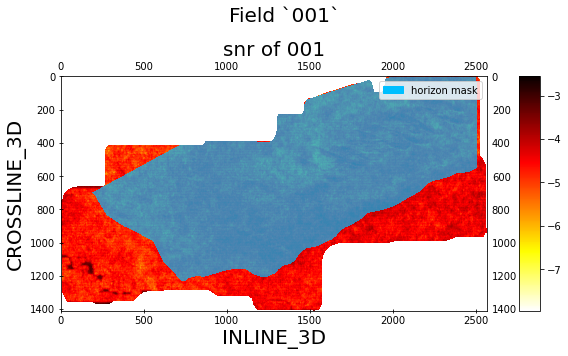

In [5]:
field.show(['snr', 'horizons:0/masks'], cmap=['hot_r', 'deepskyblue'], legend_label=['horizon mask'])

To display attributes separately provide `separate=True`.

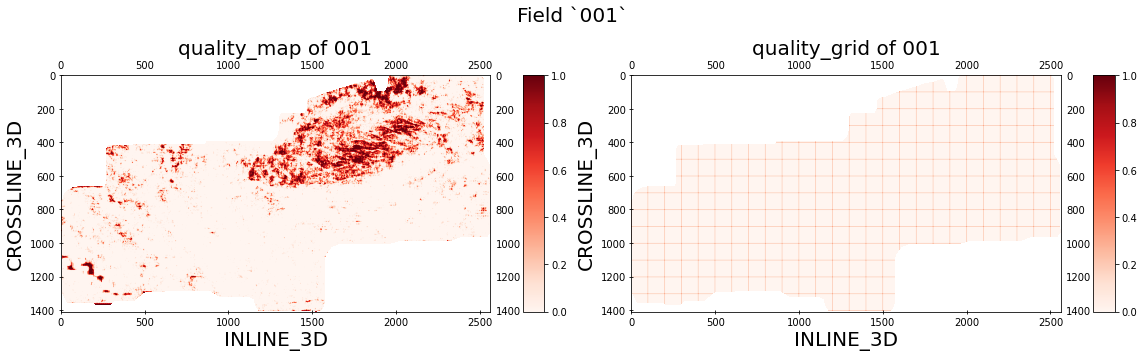

In [6]:
field.show(['quality_map', 'quality_grid'], separate=True)

# Horizon attributes

In [7]:
horizon = field.horizons[0]

One can display horizon attributes by calling `show` directly on `Horizon` instance.

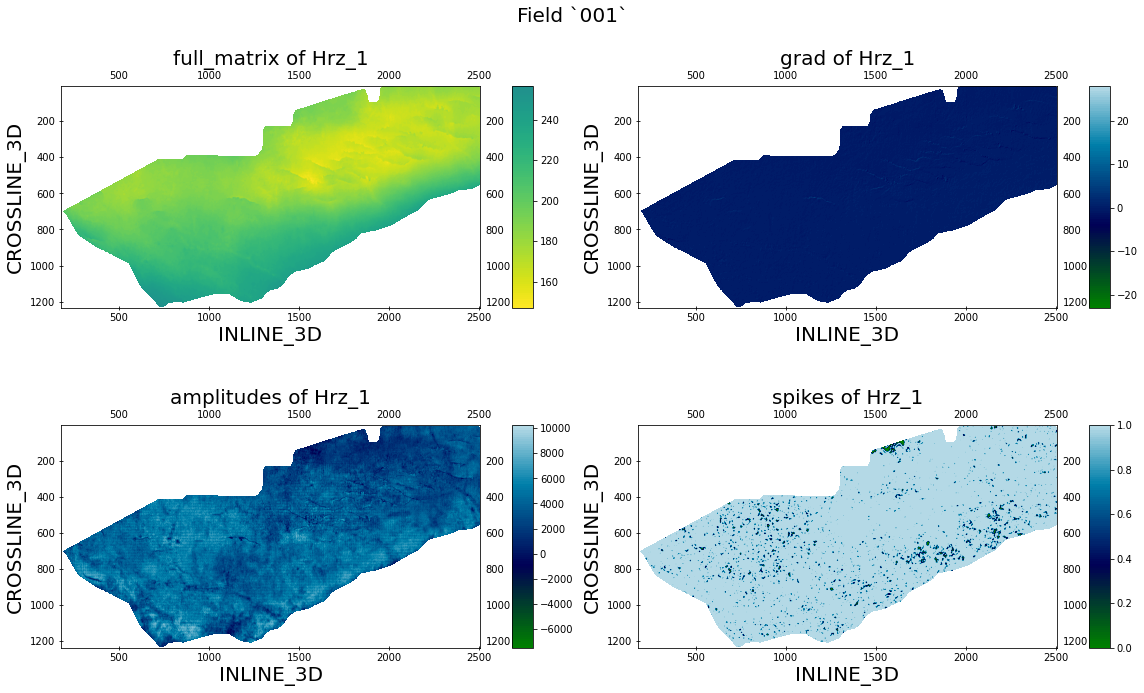

In [8]:
horizon.show(['depths', 'gradient', 'amplitudes', 'spikes'], separate=True, bbox=True, ncols=2)

# Metrics

In [9]:
def gkern(size, sigma):
    x = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(x) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def add_horizon_anomalies(horizon):
    shifts = np.zeros(horizon.matrix.shape, dtype=np.int32)

    for _ in range(np.random.randint(10, 20)):
        size = np.random.randint(10, 50)
        kernel = gkern(size, size *.3)
        kernel = kernel / kernel.max() * np.random.randint(5, 10)
        kernel = np.repeat(kernel, np.random.randint(1,4), axis=np.random.randint(2))

        i, x, h = horizon.points[np.random.choice(len(horizon))]
        i_start = i - kernel.shape[0] // 2
        i_stop = i_start + kernel.shape[0]
        x_start = x - kernel.shape[1] // 2
        x_stop = x_start + kernel.shape[1]

        if (i_start < 0) or (x_start < 0) or (i_stop > shifts.shape[0]) or (x_stop > shifts.shape[1]):
            continue

        shifts[i_start : i_stop, x_start : x_stop] += kernel.astype(np.int32)

    shifts[horizon.matrix < 0] = horizon.FILL_VALUE
    shifter = lambda matrix: matrix + shifts

    shifted = copy(horizon)
    shifted.name = f"shifted {horizon.name}"
    shifted.apply_to_matrix(shifter)
    
    return shifted

Note that additional arguments for histogram might be provided with `hist_` prefix.

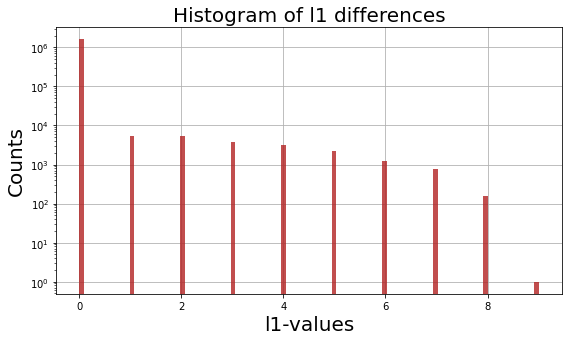

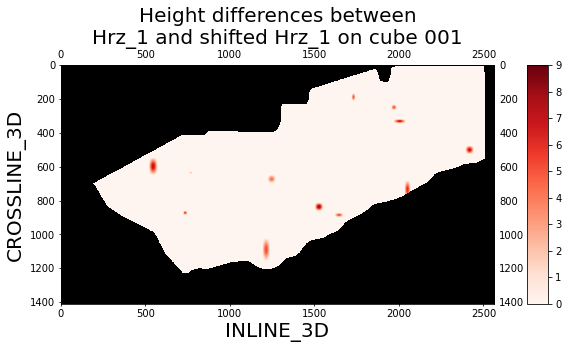

In [10]:
anomalous = add_horizon_anomalies(horizon)
horizon_metrics = HorizonMetrics([horizon, anomalous])
horizon_metrics.evaluate('compare', plot=True, printer=lambda _: None, hist_log=True);

# Samplers

In [11]:
sampler = SeismicSampler(labels=dataset.horizons, crop_shape=(256, 1, 256), threshold=0.1, mode='horizon')

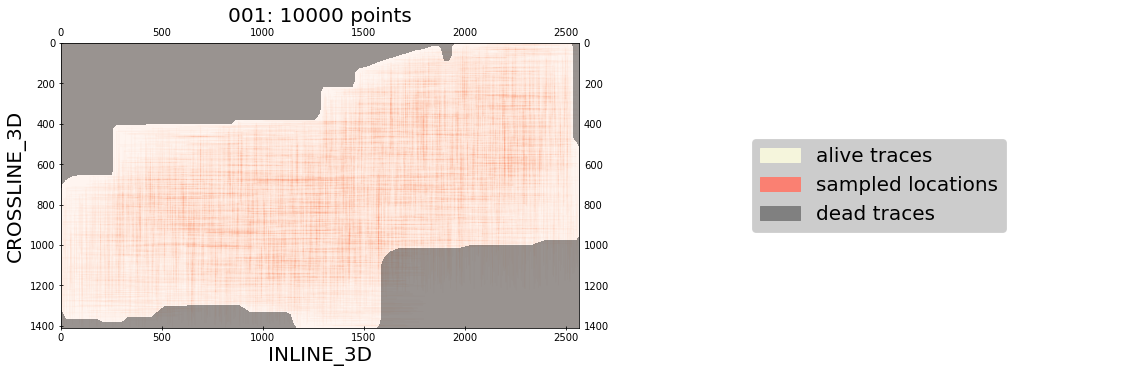

In [12]:
sampler.show_sampled()

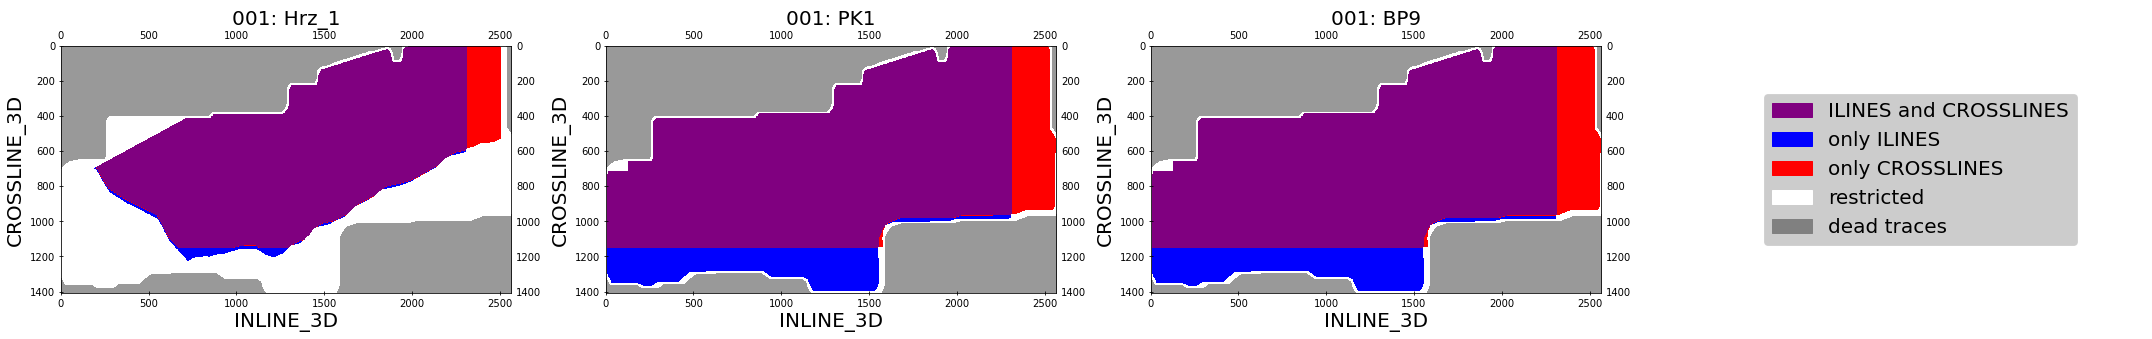

In [13]:
sampler.show_locations()

# Slides

Use `scale` parameter to enlarge/reduce figure size keeping its aspect ratio.

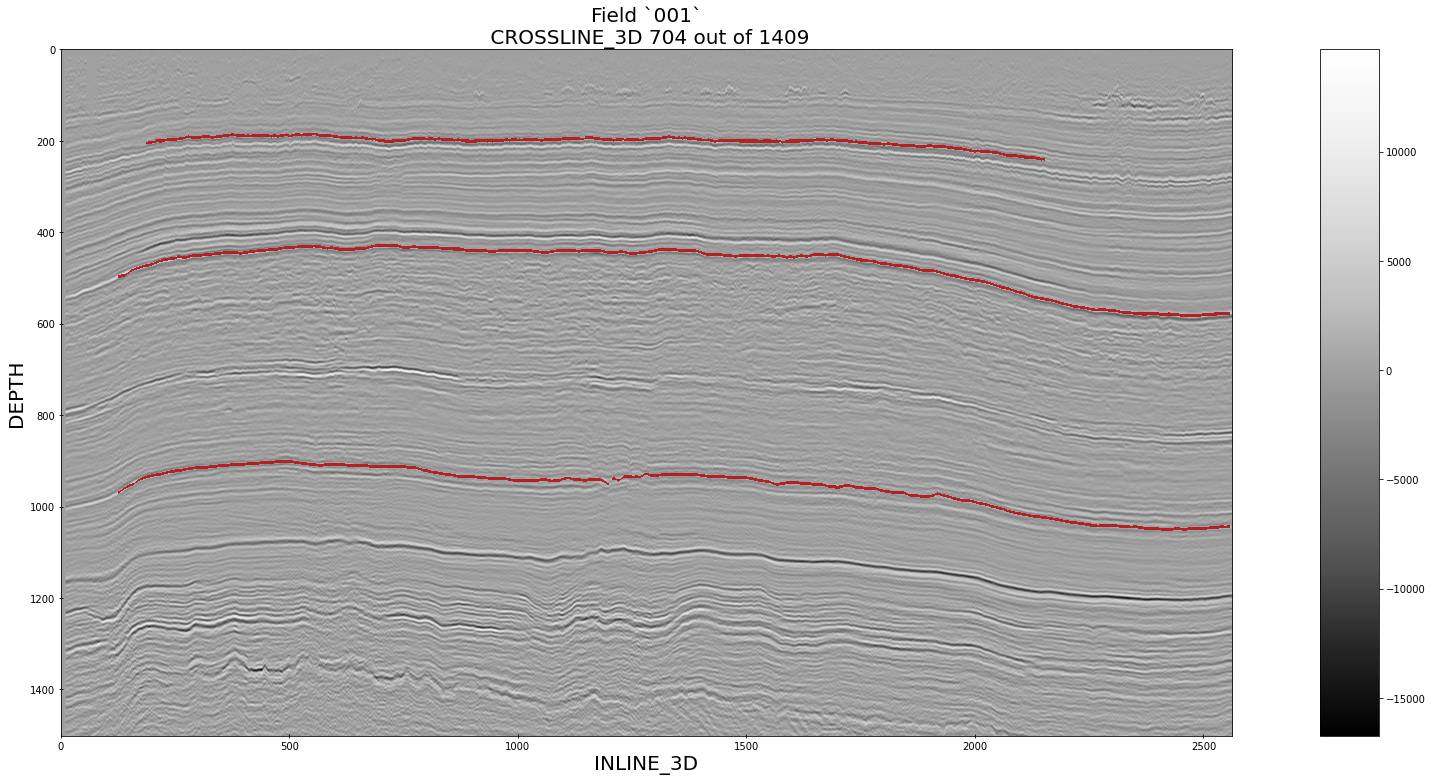

In [14]:
field.show_slide(field.shape[1] // 2, width=10, axis=1, scale=2.5)

# Extreme plotting cases

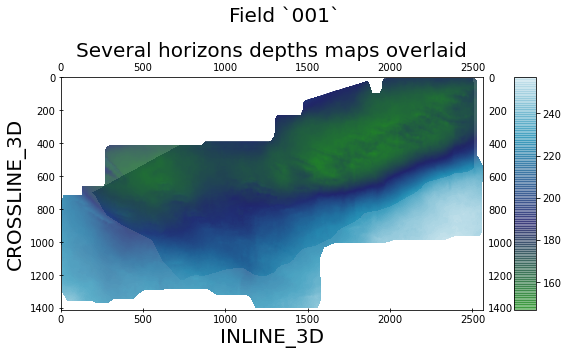

In [15]:
horizons_depths = [horizon.load_attribute('depths', dtype=np.float32) for horizon in dataset.horizons.flat]

plot_kwargs = {
    'title': 'Several horizons depths maps overlaid',
    'alpha': .5
}

horizon.show(horizons_depths, **plot_kwargs)

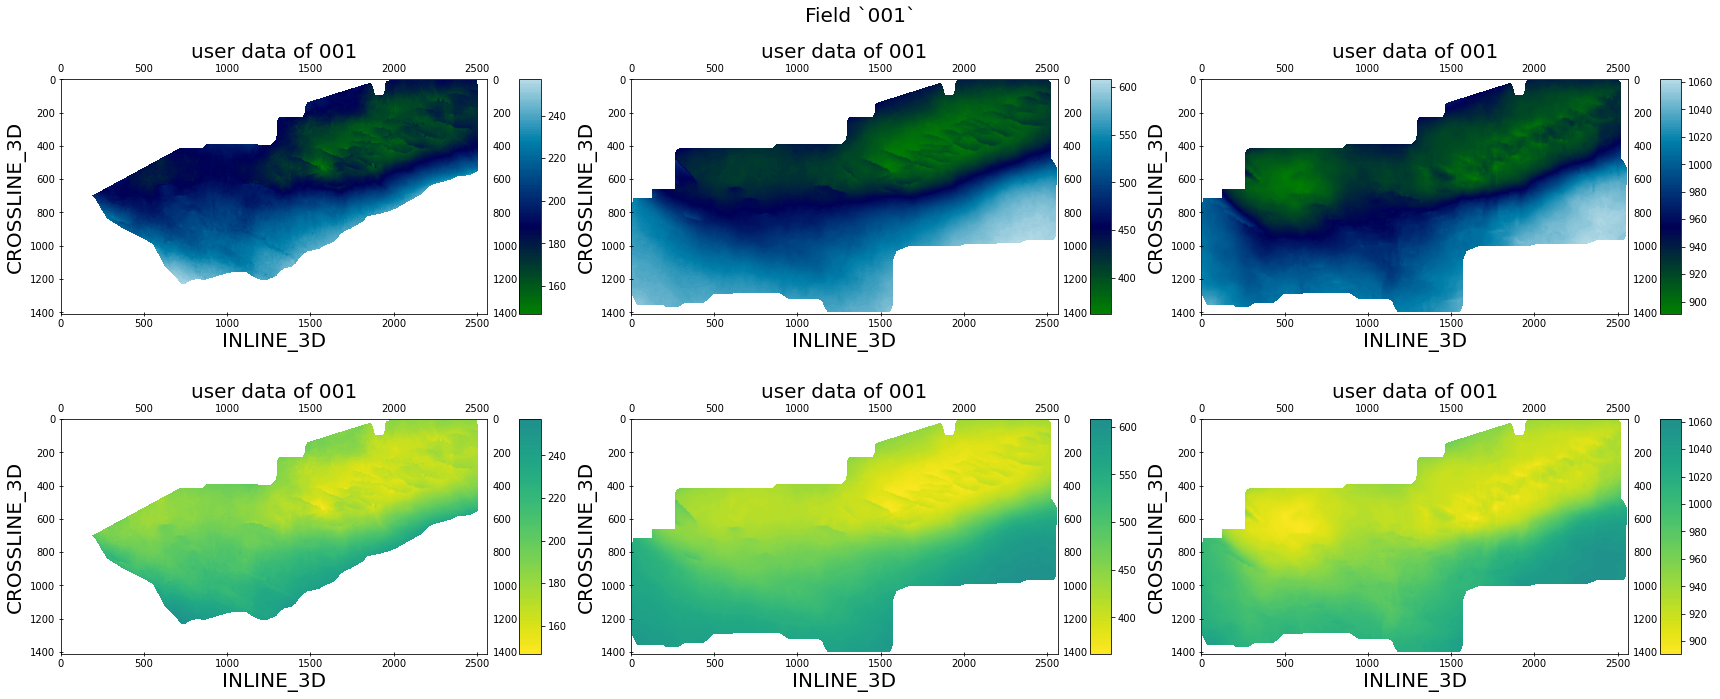

In [16]:
plot_kwargs = {
    'separate': True,
    'cmap': ['Basic'] * 3 + ['Depths'] * 3,
    'ncols': 3
}

horizon.show(horizons_depths * 2, **plot_kwargs)

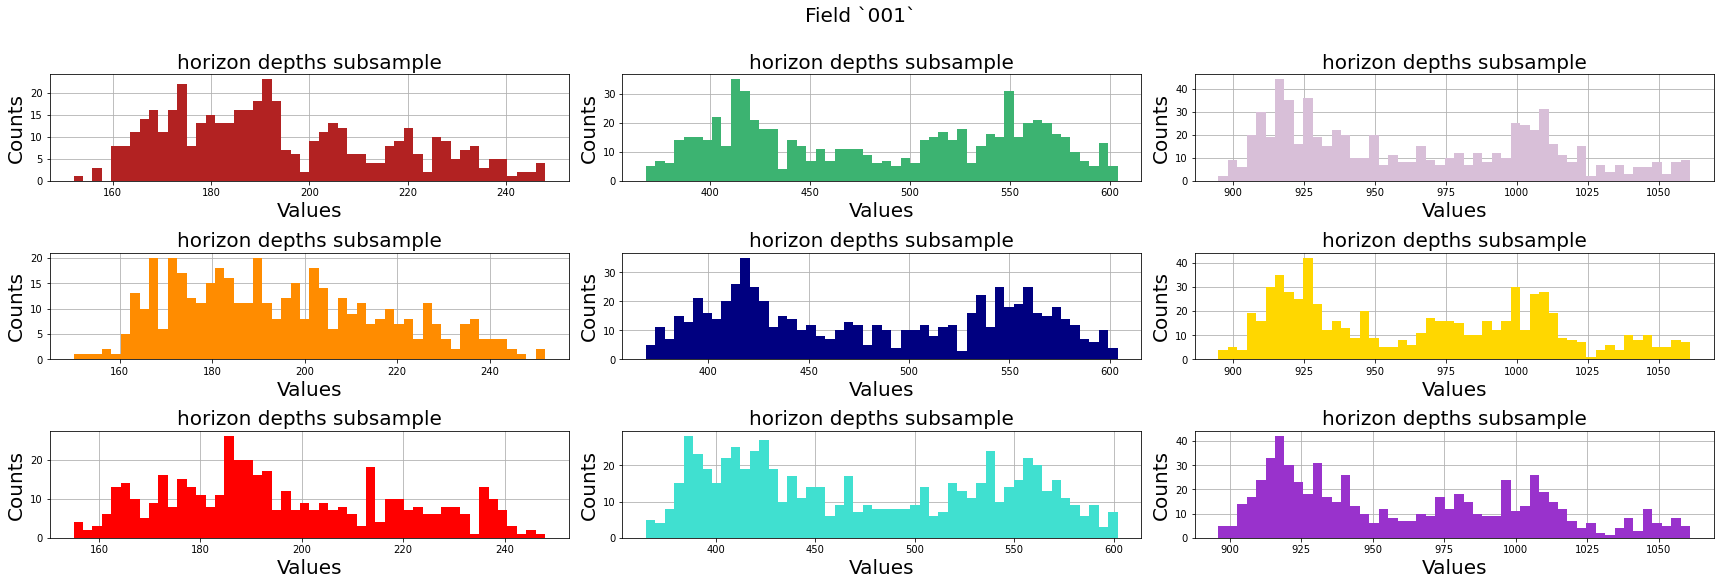

In [17]:
depths_subsamples = [np.random.choice(depths.flatten(), 1000) for depths in horizons_depths * 3]

plot_kwargs = {
    'mode': 'hist',
    'title': 'horizon depths subsample',
    'separate': True,
    'ncols': 3,
    'aspect': 3,
}

horizon.show(depths_subsamples, **plot_kwargs)

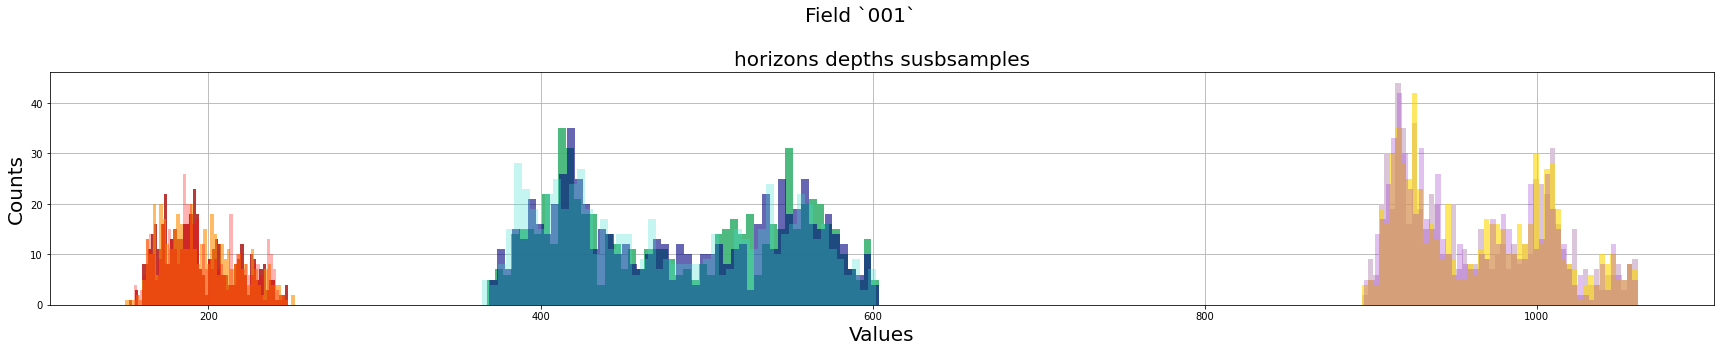

In [18]:
plot_kwargs = {
    'mode': 'hist',
    'title': 'horizons depths susbsamples',
    'scale': 3,
    'aspect': 5,
    'alpha': [.9, .9, .9, .6, .6, .6, .3, .3, .3]
}

horizon.show(depths_subsamples, **plot_kwargs)